# Resume Parser
### CCNY Fall 2021 - CSC59867 Prof. Rozet
### Team Members: Asma Sadia, Daniel Lichter, David Balaban, Maitri Patel

## Table of Contents:
* [Part 1. Problem Statement](#part-one)
* [Part 2. Exploratory Data Analysis](#part-two)
* [Part 3. Modeling](#part-three)
* [Part 4. Results](#part-four)
* [Part 5. Impact](#part-five)


**Loading Libraries**

In [1]:
#!apt-get install poppler-utils 
#!pip install pdf2image
#!pip install easyocr

In [2]:
from pdf2image import convert_from_path
import pdf2image #converts pdf 
import easyocr
import numpy as np
import PIL # Python Imaging Library
from PIL import ImageDraw # drawing bounding boxes
import tensorflow as tf
from IPython.display import display,Image
from matplotlib.pyplot import imshow
import xml.dom.minidom
import pandas as pd
import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import urllib.request
import os
import xml.etree
import cv2

from pdf2image import convert_from_path 
from IPython.display import display,Image
import easyocr
import numpy as np
import PIL # Python Imaging Library
from PIL import ImageDraw, Image # drawing bounding boxes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from annotate import *
import resume_eda

reader = easyocr.Reader(['en'])

C:\Users\davba\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\davba\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\davba\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\davba\AppData\Roaming\Python\Python37\site-

## Problem Statement <a id="part-one"></a>

Many universities and student organizations collect resume books, containing hundreds of student resumes, to send out to different companies looking to hire. Keystone Strategy's recruiting team often recieve these resume books, which they then have to manually parse to catalog simple attributes about individuals, before doing a more detailed review for fit with the organization. 

Keystone would like to automate this initial step using machine learning. A machine learning-based resume parser will save Keystone recruiters from hours of work by eliminating manual processing and analysis for every resume they receive. Using different machine learning models, an accurate and faster system can be made to parse these resumes and make hiring new employees that much easier.

## Exploratory Data Analysis <a id="part-two"></a>

Our custom dataset consists of resumes from three resume books from graduate business schools such as Tuck School of Business at Dartmouth, Haas School of Business at Berekely, and Standard Graduate School of Business. In total, there are 841 resumes of MBA candidates. The Stanford university had 428 resumes, while Berekely had 212 and Dartmouth had 201 resumes. There are 5 two page resumes with 2 from the Stanford resume book and 3 from the Dartmouth resume book. There is only one column-based resume from the Stanford resume book. We anticipate that the predictions for the column-based resumes would have poor performance due to the lack of column-based resumes in our dataset.

Below are graphs showing the breakdown of the different types of resumes in our dataset.

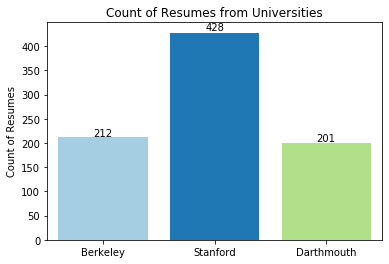

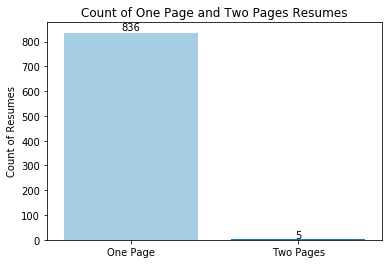

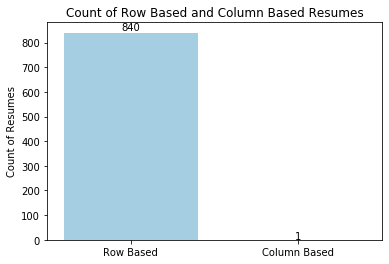

In [4]:
from resume_eda import labels

uni_count = [212,428,201]
uni=['Berkeley','Stanford','Darthmouth']
ax = sns.barplot(x = uni, y = uni_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of Resumes from Universities")
plt.show()

page_count = [836,5]
page_type=['One Page','Two Pages']
ax = sns.barplot(x = page_type, y = page_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of One Page and Two Pages Resumes")
plt.show()

base_count= [840,1]
base =['Row Based','Column Based']
ax = sns.barplot(x = base, y = base_count, palette = "Paired", saturation = 2.0)
labels(ax)
plt.title("Count of Row Based and Column Based Resumes")
plt.show()

**Data Transformation**



The resume books were in PDF format so they needed to be converted into images to function with the maskrcnn model. The individual resumes were saved as a.jpg file. From these resumes, we want to extract attributes about individuals such as education, work experience, skills, etc.  Anything not included in any of these categories will be considered extra. Therefore, we annotated the images or create borders around these attributes, known as a bounding box, to generate the training dataset. 

In [5]:
images = convert_from_path("D:\\ResumeIT\\Resume Books to Share 001\\Haas Class of 2022 Resume Book.PDF", size=(1700,2200))

To illustrate the data that goes into the model, we will look at an example resume. 

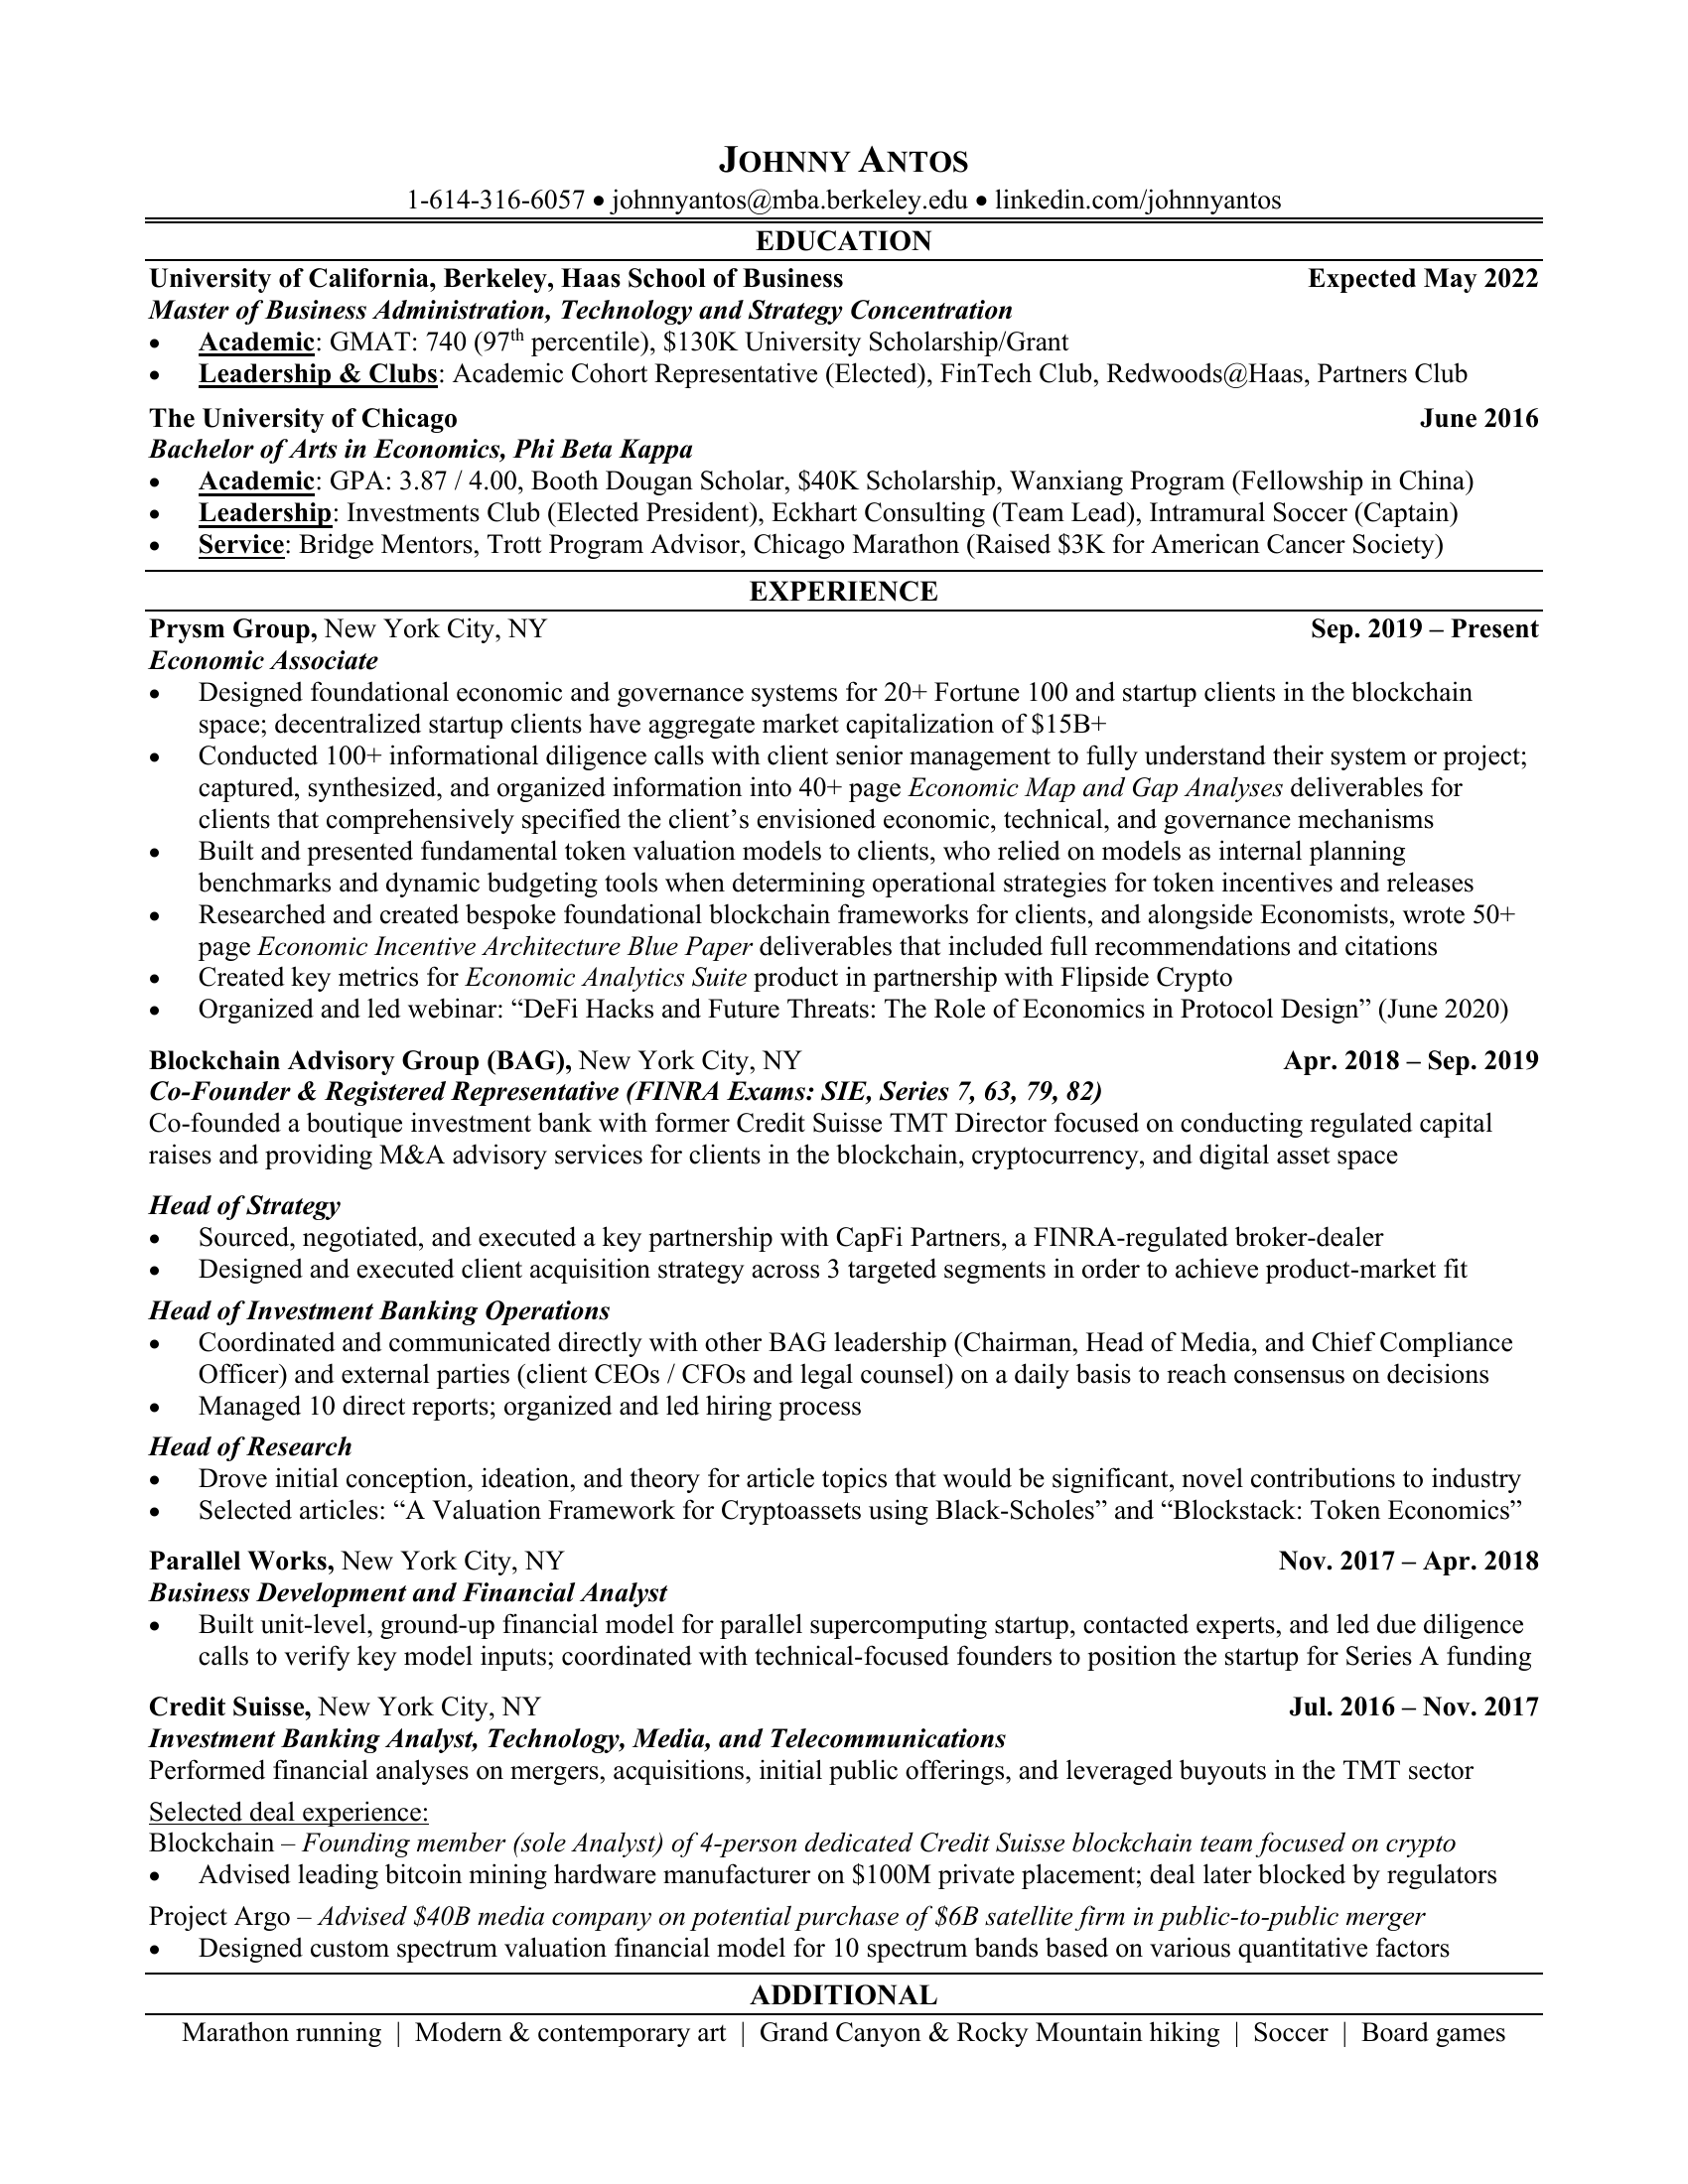

In [6]:
display(images[21])

In order to train the model, we need to extract the text from the resume, get the coordinates of the desired headers, determine what type of resume it is, and finally create and label the bounding boxes. The code below shows the process of annotating the training resumes. 

Initially this was done manually, by coming up with bounding boxes and adjusting them manually, but once we got this code running we were able to really speed everything up.

First, we need to extract the text from the resume.

In [7]:
bounds = reader.readtext(np.array(images[21]),min_size=0,slope_ths=0.2,ycenter_ths=0.7,height_ths=0.6,width_ths=0.8)
bounds[10:15]

[([[1426, 406], [1554, 406], [1554, 436], [1426, 436]],
  'June 2016',
  0.9752082891486952),
 ([[147, 435], [706, 435], [706, 477], [147, 477]],
  'Bachelor of Arts in Economics, Phi Beta Kappa',
  0.7233095837231349),
 ([[198, 470], [454, 470], [454, 502], [198, 502]],
  'Academic: GPA: 3.87',
  0.55068483933942),
 ([[469, 465], [1489, 465], [1489, 505], [469, 505]],
  '4.00, Booth Dougan Scholar; S40K Scholarship, Wanxiang Program (Fellowship in China)',
  0.6602075110716131),
 ([[197, 497], [1475, 497], [1475, 537], [197, 537]],
  'Leadership: Investments Club (Elected President), Eckhart Consulting (Team Lead), Intramural Soccer (Captain)',
  0.9624798144695812)]

Once the bounds are extracted, we start making the bounding boxes for each section of the resume. This is done using the createBoxes( ) function, which takes the bounds as input and returns the bounds of the desidered headers.

In [8]:
box = createBoxes(bounds)
box

[([[760, 228], [942, 228], [942, 258], [760, 258]],
  'EDUCATION',
  0.9141328710877468),
 ([[754, 582], [950, 582], [950, 612], [754, 612]],
  'EXPERIENCE',
  0.9769553869085477),
 ([[754, 1996], [948, 1996], [948, 2024], [754, 2024]],
  'ADDITIONAL',
  0.9526827647030819),
 ([[1370, 2034], [1520, 2034], [1520, 2066], [1370, 2066]],
  'Board games',
  0.9186789427509304)]

This piece of code determines if the resume is column based or a regularly formatted resume. Once we determine the type of resume, we create the bounding boxes accordingly. Finally, we give the proper names to each section, so we can have consistent labels for sections. This last step is important because each resume can vary greatly in how they are formatted and labeled.

In [9]:
for i in range(2, len(box)):
    if((box[i-1][0][0][0] >= 500) != (box[i-2][0][0][0] >=500)):
        columns = True
        break
    else:
        columns = False

if(columns):
    new_bounds= createColumnBounds(box)
else:
    new_bounds=createNormalBounds(box)
new_bounds = list(map(lambda x: ([x[0][3], x[0][2],x[0][1],x[0][0]],x[1]) if x[0][3]!=[0,0] else x, new_bounds))
properNameBounds= giveProperNames(new_bounds)
properNameBounds

[([[0, 218], [1700, 218], [1700, 0], [0, 0]], 'Personal Info'),
 ([[0, 572], [1700, 572], [1700, 228], [0, 228]], 'Education'),
 ([[0, 1986], [1700, 1986], [1700, 582], [0, 582]], 'Work Experience'),
 ([[0, 2200], [1700, 2200], [1700, 1996], [0, 1996]], 'Extra')]

Now, we draw the boxes using the coordinates found, and can see that this resume is split correctly.

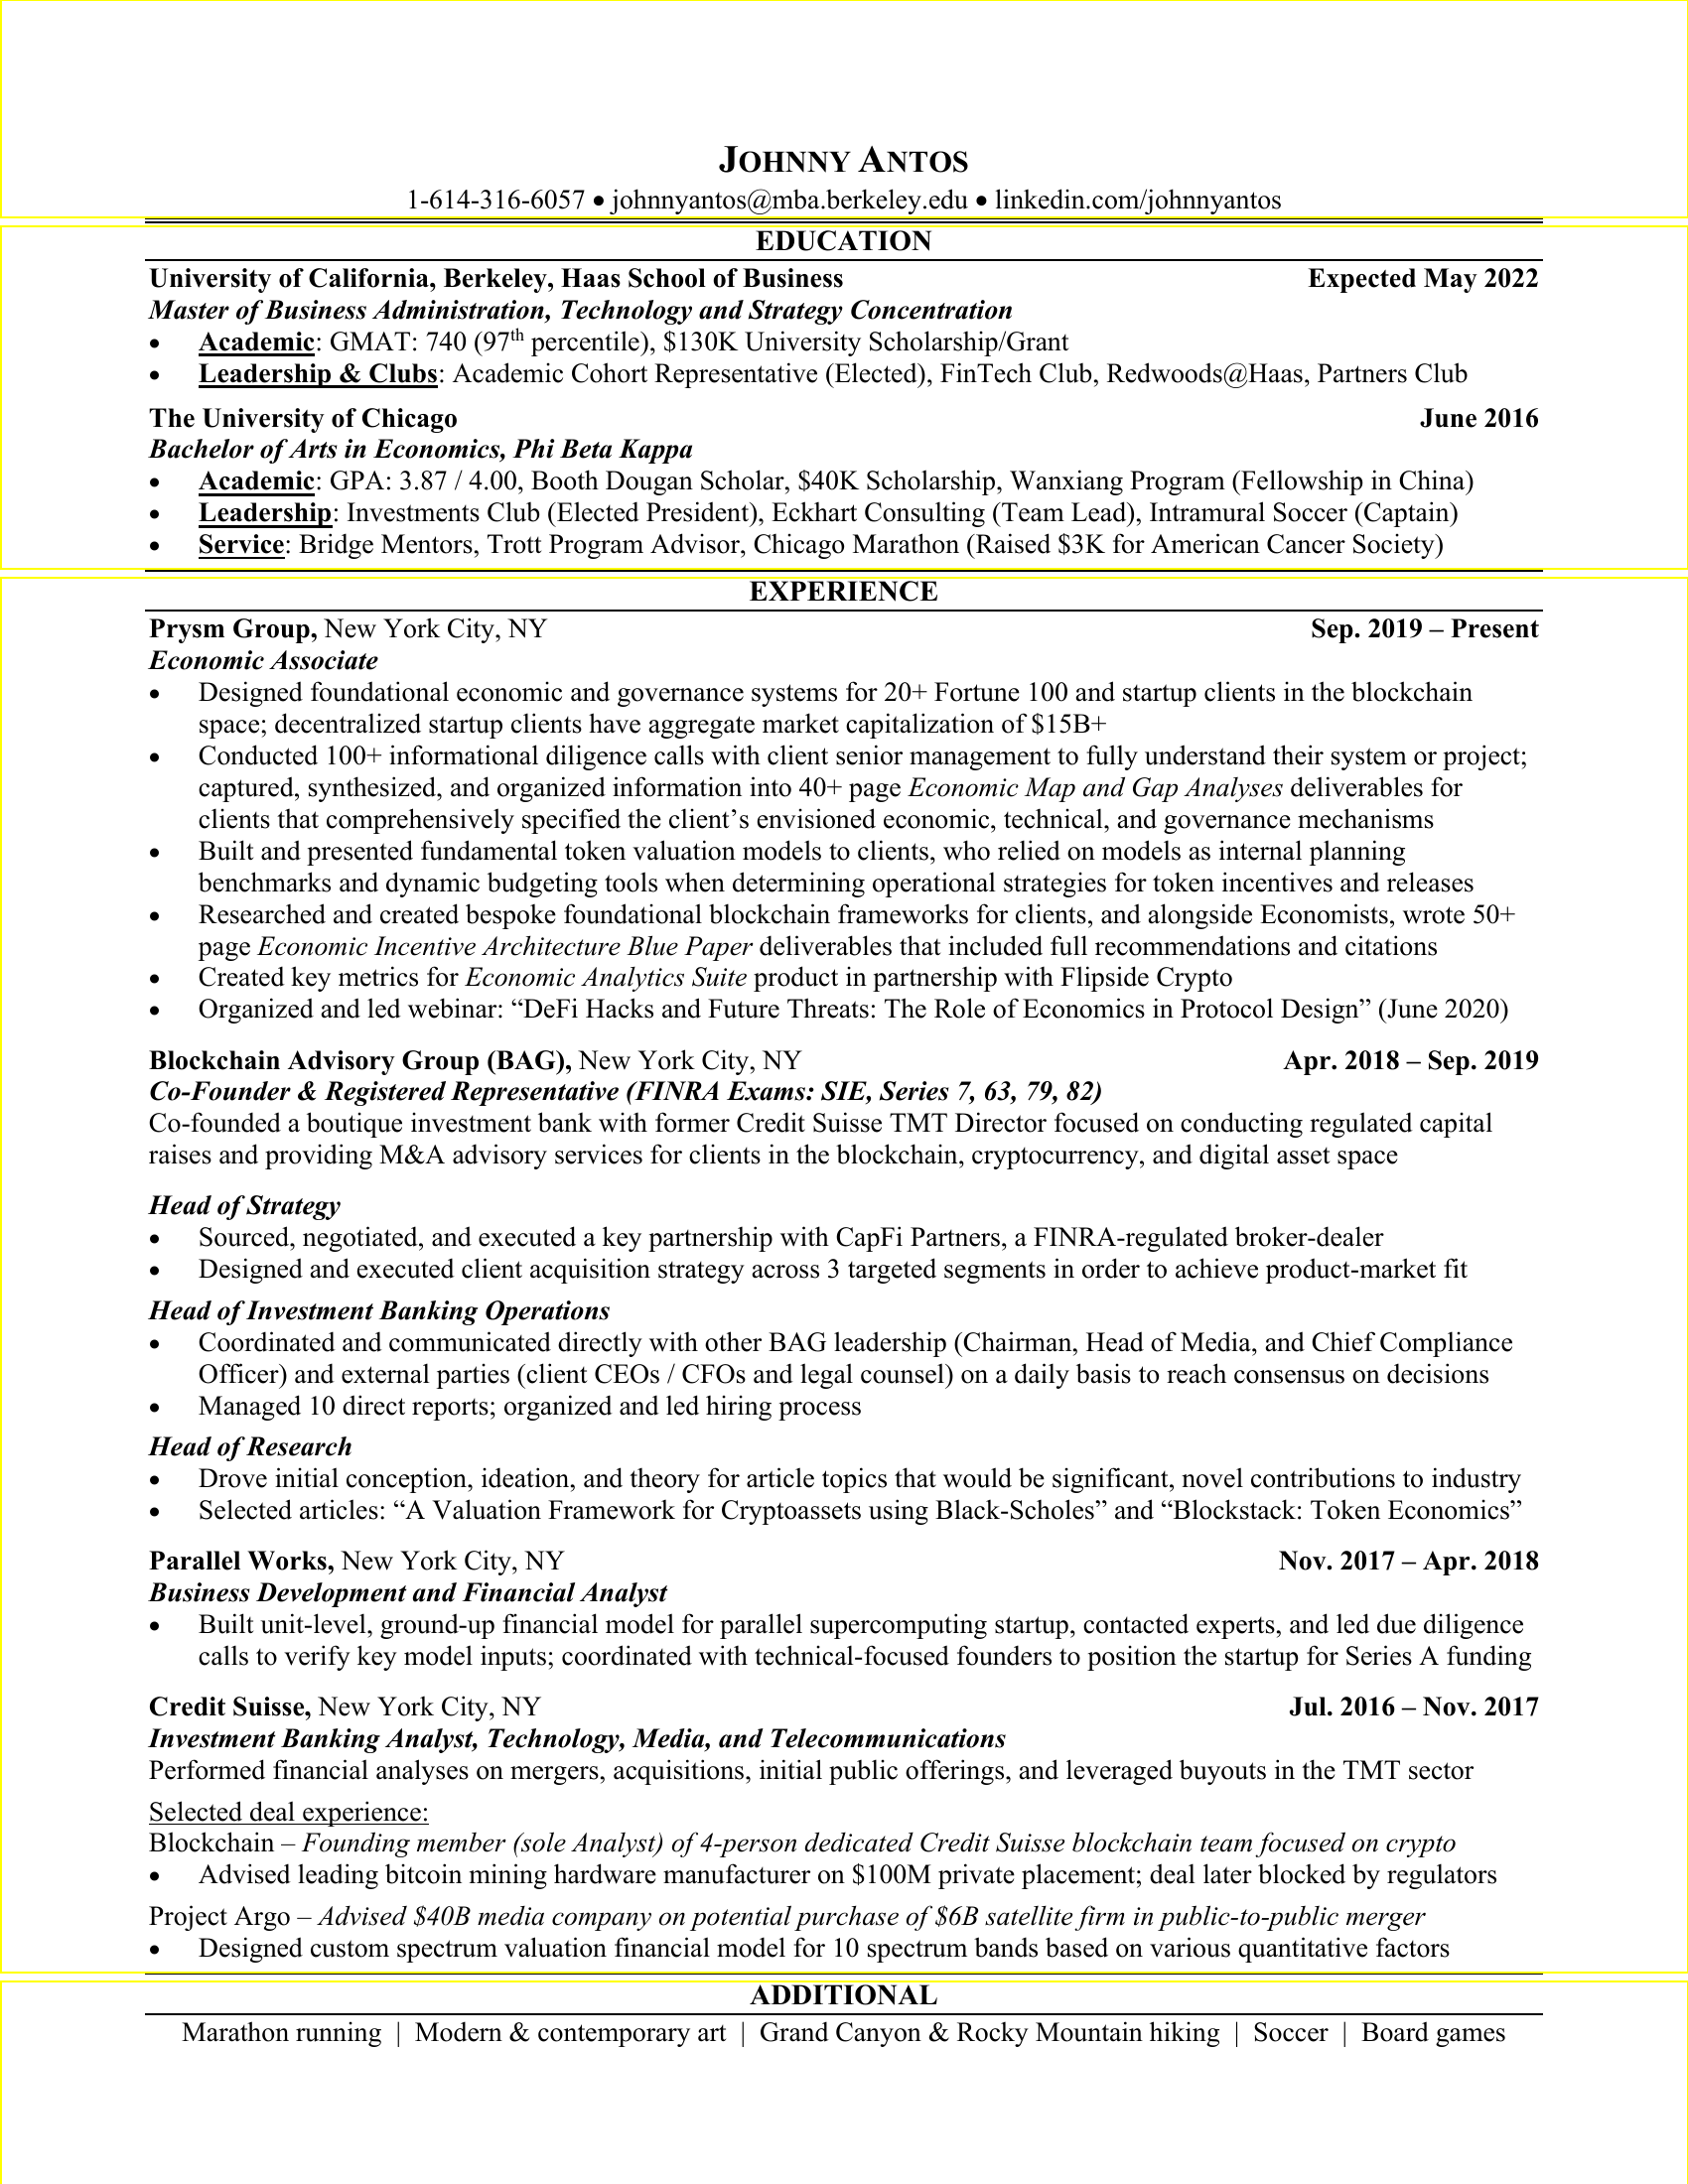

In [10]:
draw_boxes(images[21],properNameBounds)

We saved the bounding box coordinates in the annotation XML file corresponding to the respective resume. Once we have collected the annotations, we can finally train the model.

## Modeling <a id="part-three"></a>

The modeling approach that we took to create the resume parsing model was to use MaskRCNN and EasyOCR to parse through the resumes and extract the information.

MaskRCNN is a pre-trained model generally used for object detection. 
We trained this model on the resumes available to us and used it to classify different portions of a resume using bounding boxes for each section of the resume, the weights that we used prior to training came from COCO dataset and are pretrained with 80 different classes on about 330K images

MaskRCNN Link: https://github.com/matterport/Mask_RCNN

COCO Link: https://cocodataset.org/#home

Then for the text extraction part we used EasyOCR model which is an Optical Character Recognition model that is already trained on multiple languages (including english), has very high accuracy and it's very easy to use.

EasyOCR Link: https://github.com/JaidedAI/EasyOCR

Below you can see how the actual app is using our models, we defined this function `run_model(img_array)` that takes in an array with all the pictures you want to run the model on and runs it. 

The function starts by loading the maskrcnn model and then for every picture it predicts the sections, then for every section in a picture it will extract the information using EasyOCR and save that information in a dataframe containing a row with the information from each image. The function returns a dataframe that has the parsed information out of every resume in the array passed as input

In [11]:
def run_model(img_array):
    CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']
    
    class SimpleConfig(mrcnn.config.Config):
        NAME = "coco_inference"
        
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1
    
        NUM_CLASSES = len(CLASS_NAMES)
    
    model = mrcnn.model.MaskRCNN(mode="inference", 
                                 config=SimpleConfig(),
                                 model_dir=os.getcwd())
    
    model.load_weights(filepath=r'D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5', 
                       by_name=True)
    
    class_dict = {'bg' : 0, 
                  'Personal Info' : 1, 
                  'Education' : 2,
                  'Skills' : 3,
                  'Projects' : 4,
                  'Work Experience' : 5,
                  'Extra' : 6
                }
    
    inv_class_dict = {0:'bg', 
                  1:'Personal Info', 
                  2:'Education',
                  3:'Skills',
                  4:'Projects',
                  5:'Work Experience',
                  6: 'Extra'
                }
    
    sections = ['Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']
    extracted_info_df = pd.DataFrame(columns=sections)
    
    #Assuming an array of images in cv2 format: img_array
    for image in img_array:
        
        pred = model.detect([image], verbose=0)
        pred = pred[0]
        #The bnd box outputed is [y1,x1,y2,x2]
        
        full_info = list()
        class_list = list()
        for i in range(len(pred['rois'])):
            img_pil = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            temp_img = PIL.Image.fromarray(img_pil)
            current_bnd_box = pred['rois'][i]
            current_box_class = pred['class_ids'][i]
            #pil_img.crop(box=[x1,y1,x2,y2])
            crop_box = [current_bnd_box[1], current_bnd_box[0], current_bnd_box[3], current_bnd_box[2]]
            crop_img = temp_img.crop(crop_box)
            
            #text for this section
            section_text = ""
            bounds = reader.readtext(np.array(crop_img),min_size=0,slope_ths=0.2,ycenter_ths=0.7,height_ths=0.6,width_ths=0.8)
            for b in bounds:
                section_text += " " + b[1]
            full_info.append([section_text])
            class_list.append(inv_class_dict[current_box_class])
            
        add_to_df = dict(zip(class_list,full_info))
        
        for key in sections:
            if key in add_to_df:
                continue 
            else:
                add_to_df[key] = [""]
        
        temp_df = pd.DataFrame.from_dict(add_to_df)
            
        extracted_info_df = extracted_info_df.append(temp_df, ignore_index = True)
    
    return extracted_info_df

files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes_Smaller')
img_array = list()
for name in files:
    image = cv2.imread(r'D:\\ResumeIT\\Testing\\Resumes_Smaller\\' + name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array.append(image)

extracted_df = run_model(img_array)
extracted_df.head()

Instructions for updating:
Colocations handled automatically by placer.


,Personal Info,Education,Skills,Projects,Work Experience,Extra
0,Dariush Sarrafzadeh 650-484-8500 dariush_sarr...,"EDUCATION University of California, Berkeley,...",,,Strategic advisory firm providing buy and sel...,ADDITIONAL Academic Fellowship: DigitalDx Ven...
1,MUKUNDHA SASTRY 813-786-3881 msastry@mba.berk...,"EDUCATON University of California, Berkeley, ...",,,"EXPERIENCE Netflix, Inc Los Angeles, CA Mar 2...","SERVICE & LEADERSHIP Writer Coach Connection,..."
2,Nicole Savage +1310 266 2609 . nicole savage@...,"EDUCATON University of California, Berkeley, ...",,,Designed a telemedicine platform for diabetes...,ADDIIONAL Fluent in French with experience li...
3,Joseph Wayne Scammerhorn 913-704-9151 scammer...,"University of California, Berkeley, Haas Scho...",,,IIDA Intern (Ucl: Zuzu - Fresen) Working dire...,Languages: Basic understanding of Korean and ...
4,DREW SCHNEIDER 914-886-3916 drew_schneider@mb...,"University of California, Berkeley, Haas Scho...",,,"Bluevine Capital Inc , New Orleans, LA 2017-2...",ADDIIONAL Pacific Community Ventures; Volunte...


Here we ran the model with just 5 resumes so that we could see it working, but you can run this with as many resumes you need, just might need to wait a bit for it.

## Results <a id="part-four"></a>

Once the first version of the model was trained we were finally able to get a prediction out of it and it looked a lot like this:

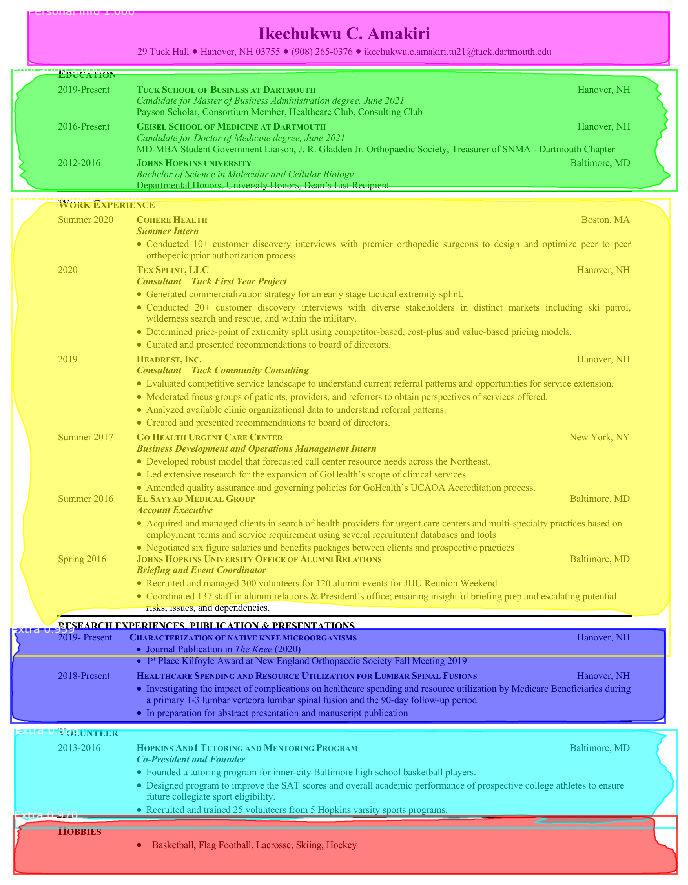

In [12]:
CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath='D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5', 
                   by_name=True)

image = cv2.imread("D:\\ResumeIT\\old_Resumes_11_30\\s112.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = model.detect([image], verbose=0)

pred = pred[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=pred['rois'], 
                                  masks=pred['masks'], 
                                  class_ids=pred['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=pred['scores'])

Where above you can see the predictions that our model made for that particular resume, and the bounding box has its class and confidence level on the top left corner

After a lot of research we concluded that the best evaluation metric for an object segmentation model would be mAP (Mean Average Precision). To get those metrics calculate the average precision for each class in your data based on your model predictions. Average precision is related to the area under the precision-recall curve for a class. Then we took the mean out of all those values so that we could find out the overall mAP of our model.

To calculate the AP we used a function already included in MRCNN package called compute_ap

`mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.75)`

The function takes in the ground truth boxes, ids and masks, as well as the predicted boxes, ids, masks and scores, and also a final parameter called `iou_threshold` which determines what's the threshold IoU (Intersect over Union) rate that categorizes a prediction as true or false. So we ran the metrics for three different IoUs to see how it affected the performance of the model, we ran on IoU = [0.75, 0.85, 0.95]


Before we can run the snippets for performance, lets just define this two functions that are going to make life a lot easier:

In [13]:
#Section class =  1, "Personal Info")
#Section class =  2, "Education")
#Section class =  3, "Skills")
#Section class =  4, "Projects")
#Section class =  5, "Work Experience")
#Section class =  6, "Extra")

class_dict = {'bg' : 0, 
              'Personal Info' : 1, 
              'Education' : 2,
              'Skills' : 3,
              'Projects' : 4,
              'Work Experience' : 5,
              'Extra' : 6
             }

# A helper method to extract the bounding boxes from the annotation file
def extract_boxes(filename):
    class_dict = {'bg' : 0, 
              'Personal Info' : 1, 
              'Education' : 2,
              'Skills' : 3,
              'Projects' : 4,
              'Work Experience' : 5,
              'Extra' : 6
             }
    
    tree = xml.etree.ElementTree.parse(filename)

    root = tree.getroot()

    boxes = list()
    for obj in root.findall('./object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        coors = [xmin, ymin, xmax, ymax]
        class_id = class_dict[name]
        box_array = [class_id,coors]
        print(box_array)
        boxes.append(box_array)    


    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height

def load_mask(path_annotations):
    boxes, w, h = extract_boxes(path_annotations)
    masks = np.zeros([h, w, len(boxes)], dtype='uint8')

    class_ids = list()
    for i in range(len(boxes)):
        obj = boxes[i]
        box = obj[1]
        row_s, row_e = box[1], box[3]
        col_s, col_e = box[0], box[2]
        masks[row_s:row_e, col_s:col_e, i] = 1
        class_ids.append(obj[0])
    return masks, np.asarray(class_ids, dtype='int32')

For IoU = 75%

In [15]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_75 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pred = model.detect([image], verbose=0)
    pred = pred[0]
    
    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'    
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])
    
    masks, class_id = load_mask(xml_path)
    
    ap_mult_res_try_75 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.75)
    ap_results_75.append(ap_mult_res_try_75)
print(ap_results_75[0])

['Test0.jpg', 'Test1.jpg', 'Test10.jpg', 'Test11.jpg', 'Test12.jpg', 'Test13.jpg', 'Test14.jpg', 'Test15.jpg', 'Test16.jpg', 'Test17.jpg', 'Test18.jpg', 'Test19.jpg', 'Test2.jpg', 'Test20.jpg', 'Test21.jpg', 'Test22.jpg', 'Test23.jpg', 'Test24.jpg', 'Test25.jpg', 'Test26.jpg', 'Test27.jpg', 'Test28.jpg', 'Test29.jpg', 'Test3.jpg', 'Test30.jpg', 'Test31.jpg', 'Test32.jpg', 'Test33.jpg', 'Test34.jpg', 'Test35.jpg', 'Test36.jpg', 'Test37.jpg', 'Test38.jpg', 'Test39.jpg', 'Test4.jpg', 'Test40.jpg', 'Test41.jpg', 'Test42.jpg', 'Test43.jpg', 'Test44.jpg', 'Test45.jpg', 'Test46.jpg', 'Test47.jpg', 'Test48.jpg', 'Test49.jpg', 'Test5.jpg', 'Test6.jpg', 'Test7.jpg', 'Test8.jpg', 'Test9.jpg']
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 202]]
[2, [0, 212, 1700, 524]]
[5, [0, 534, 1700, 1902]]
[6, [0, 1912, 1700, 2200]]
[1, [0

[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 170

So on the code above we can see the output of the compute_ap() function for one of the resumes and in the case of the 75% IoU we get:
* Average Precision = 1.0
* Precision for each section in this resume = [1, 1, 1, 1, 1, 0]
* Recall for each section in this resume = [0, 0.25, 0.5, 0.75, 1, 1]
* And the last part are the masks for the bounding boxes

So here we can see that our model performed incredibly well, but due to the low IoU Threshold and also some overfitting so we expect our scores to change a lot once we change the IoU Threshold. Moreover, we can see the overfitting happening with precision, where it did almost perfectly and failed to detect a section correctly, and recall where the scores varied significantly, but the lower scores where attributed with a perfect precision. 

For IoU = 85%

In [16]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_85 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pred = model.detect([image], verbose=0)
    pred = pred[0]
    
    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'    
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])
    
    masks, class_id = load_mask(xml_path)
    
    ap_mult_res_try_85 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.85)
    ap_results_85.append(ap_mult_res_try_85)
print(len(ap_results_85))
print(ap_results_85[0])

['Test0.jpg', 'Test1.jpg', 'Test10.jpg', 'Test11.jpg', 'Test12.jpg', 'Test13.jpg', 'Test14.jpg', 'Test15.jpg', 'Test16.jpg', 'Test17.jpg', 'Test18.jpg', 'Test19.jpg', 'Test2.jpg', 'Test20.jpg', 'Test21.jpg', 'Test22.jpg', 'Test23.jpg', 'Test24.jpg', 'Test25.jpg', 'Test26.jpg', 'Test27.jpg', 'Test28.jpg', 'Test29.jpg', 'Test3.jpg', 'Test30.jpg', 'Test31.jpg', 'Test32.jpg', 'Test33.jpg', 'Test34.jpg', 'Test35.jpg', 'Test36.jpg', 'Test37.jpg', 'Test38.jpg', 'Test39.jpg', 'Test4.jpg', 'Test40.jpg', 'Test41.jpg', 'Test42.jpg', 'Test43.jpg', 'Test44.jpg', 'Test45.jpg', 'Test46.jpg', 'Test47.jpg', 'Test48.jpg', 'Test49.jpg', 'Test5.jpg', 'Test6.jpg', 'Test7.jpg', 'Test8.jpg', 'Test9.jpg']
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 202]]
[2, [0, 212, 1700, 524]]
[5, [0, 534, 1700, 1902]]
[6, [0, 1912, 1700, 2200]]
[1, [0

[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 170

So on the code above we can see the output of the compute_ap() function for one of the resumes and in the case of the 85% IoU we get:
* Average Precision = 1.0
* Precision for each section in this resume = [1, 1, 1, 1, 1, 0]
* Recall for each section in this resume = [0, 0.25, 0.5, 0.75, 1, 1]
* And the last part are the masks for the bounding boxes

So here we can see the same thing happening as it did with the IoU of 75% even down to the same scores for the same resume, however when we look at the mAP we will see a big difference between these two scores

For IoU = 95%

In [17]:
print(os.listdir(r'D:\\ResumeIT\\Testing\\Resumes'))
files = os.listdir(r'D:\\ResumeIT\\Testing\\Resumes')

ap_results_95 = list()

for name in files:
    img_path = 'D:\\ResumeIT\\Testing\\Resumes\\' + name
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pred = model.detect([image], verbose=0)
    pred = pred[0]
    
    xml_path = 'D:\\ResumeIT\\Testing\\Resume_Annotations\\' + name[:-4] +'.xml'    
    b, h, w = extract_boxes(xml_path)
    boxes = list()
    for box in b:
        boxes.append(box[1])
    
    masks, class_id = load_mask(xml_path)
    
    ap_mult_res_try_95 = mrcnn.utils.compute_ap(np.array(boxes), class_id, masks, pred['rois'],pred['class_ids'], pred['scores'],pred['masks'],iou_threshold=0.95)
    ap_results_95.append(ap_mult_res_try_95)
print(len(ap_results_95))
print(ap_results_95[0])

['Test0.jpg', 'Test1.jpg', 'Test10.jpg', 'Test11.jpg', 'Test12.jpg', 'Test13.jpg', 'Test14.jpg', 'Test15.jpg', 'Test16.jpg', 'Test17.jpg', 'Test18.jpg', 'Test19.jpg', 'Test2.jpg', 'Test20.jpg', 'Test21.jpg', 'Test22.jpg', 'Test23.jpg', 'Test24.jpg', 'Test25.jpg', 'Test26.jpg', 'Test27.jpg', 'Test28.jpg', 'Test29.jpg', 'Test3.jpg', 'Test30.jpg', 'Test31.jpg', 'Test32.jpg', 'Test33.jpg', 'Test34.jpg', 'Test35.jpg', 'Test36.jpg', 'Test37.jpg', 'Test38.jpg', 'Test39.jpg', 'Test4.jpg', 'Test40.jpg', 'Test41.jpg', 'Test42.jpg', 'Test43.jpg', 'Test44.jpg', 'Test45.jpg', 'Test46.jpg', 'Test47.jpg', 'Test48.jpg', 'Test49.jpg', 'Test5.jpg', 'Test6.jpg', 'Test7.jpg', 'Test8.jpg', 'Test9.jpg']
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 197]]
[2, [0, 207, 1700, 543]]
[5, [0, 553, 1700, 1924]]
[6, [0, 1934, 1700, 2200]]
[1, [0, 0, 1700, 202]]
[2, [0, 212, 1700, 524]]
[5, [0, 534, 1700, 1902]]
[6, [0, 1912, 1700, 2200]]
[1, [0

[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 276]]
[2, [0, 286, 1700, 778]]
[5, [0, 788, 1700, 1866]]
[6, [0, 1876, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 715]]
[5, [0, 725, 1700, 1940]]
[6, [0, 1950, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 561]]
[5, [0, 571, 1700, 1786]]
[6, [0, 1796, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 201]]
[2, [0, 211, 1700, 680]]
[5, [0, 690, 1700, 1882]]
[6, [0, 1892, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 1700, 2200]]
[1, [0, 0, 1700, 204]]
[2, [0, 214, 1700, 390]]
[5, [0, 400, 1700, 1906]]
[6, [0, 1916, 170

So on the code above we can see the output of the compute_ap() function for one of the resumes and in the case of the 95% IoU we get:
* Average Precision = 0.0
* Precision for each section in this resume = [0, 0, 0, 0, 0, 0]
* Recall for each section in this resume = [0, 0, 0, 0, 0, 1]
* And the last part are the masks for the bounding boxes

So here we can see that the threshold of 95% was too much for our model, returning 0 scores, which is understandable since the model has not been trained with a lot of resumes so there are a lot of small differences between the predicted and ground truth that even though might not affect how our whole app work will return a really bad score when evaluated 

And then finally a script to calculate the mAP for each of these IoU thresholds:

In [18]:
map_75_values = list()
map_85_values = list()
map_95_values = list()
for i in range(len(ap_results_75)):
    map_75_values.append(ap_results_75[i][0])
    map_85_values.append(ap_results_85[i][0])
    map_95_values.append(ap_results_95[i][0])

map_75 = sum(map_75_values) / len(map_75_values)
map_85 = sum(map_85_values) / len(map_85_values)
map_95 = sum(map_95_values) / len(map_95_values)

print(map_75)
print(map_85)
print(map_95)

0.9453333342075347
0.7340833340088527
0.0016666666666666666


Above we can see the mAP for each IoU Threshold on the 50 testing resumes, so for 75% IoU we got almost a 95% mAP which is very good, but again might be too good to be true since there might be some overfitting involved, then we can see that the 85% IoU Threshold had a mAP score of 73%, which is very good since we believe an 85% IoU threshold is enough for the model to be able to correctly find the sections and that even though there might be some overlapping it's been a very rare prediction. Finally, for the 95% IoU Threshold we see the abismal score of 0.167%, which again is understandable due to the ammount of training this model has gone through (Only about 850 resumes)

Before we demonstrate how we train the model, we need to address the underperforming parts of our model, the column based resumes where as you can see below our model is not very good at detecting:

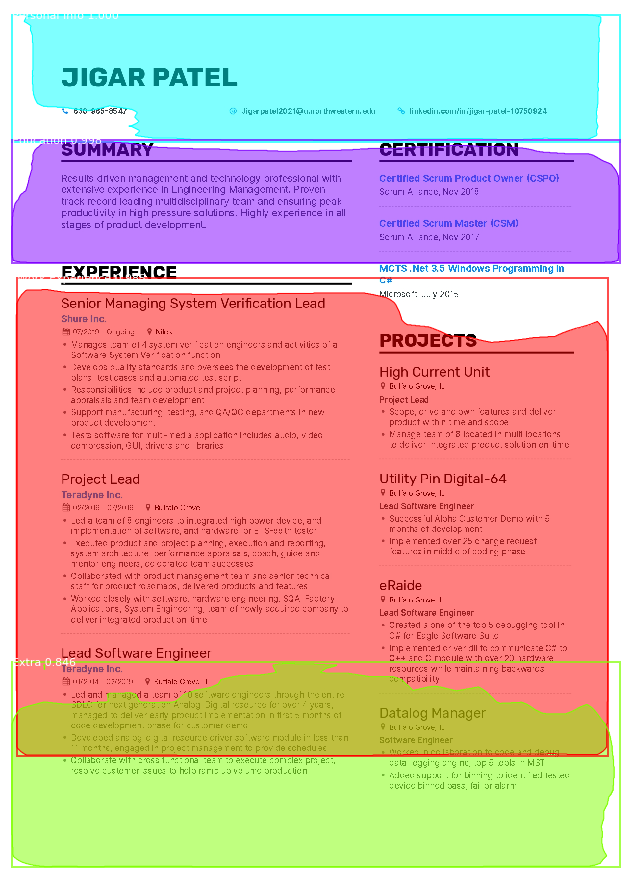

In [19]:
CLASS_NAMES = ['BG', 'Personal Info', 'Education', 'Skills', 'Projects', 'Work Experience', 'Extra']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath='D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5', 
                   by_name=True)

image = cv2.imread(r'C:\\Users\\davba\\Downloads\\mem_resume_book-2_pages-to-jpg-0001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = model.detect([image], verbose=0)

pred = pred[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=pred['rois'], 
                                  masks=pred['masks'], 
                                  class_ids=pred['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=pred['scores'])

### Demonstrate how you train and save a final version of model for use by your actual product.

To actually train the model we used a couple of methods from MRCNN as well as wrote our own methods, so the first main thing we did was to expand the Dataset class that is defined in the MRCNN package so that we could load and work with our dataset, there are three methos being used:

1. load_dataset: This method will load the dataset and based on the `is_train` parameter will make it into a training or validation set

2. load_masks: This method creates the masks for each section based on the bounding box, it uses the `extract_boxes` method to get the desired values

3. extract_boxes: A method that takes in a xml file and extract the important information, the bounding boxes described in the xml file

```
#Using Keras==2.2.5 and tensorflow==1.13.1
class ResumeDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        # Adding all possible sections
        self.add_class("dataset", 1, "Personal Info")
        self.add_class("dataset", 2, "Education")
        self.add_class("dataset", 3, "Skills")
        self.add_class("dataset", 4, "Projects")
        self.add_class("dataset", 5, "Work Experience")
        self.add_class("dataset", 6, "Extra")
        
        images_dir = dataset_dir + '\\Resumes\\'
        annotations_dir = dataset_dir + '\\Resume_Annotations\\'

        for filename in os.listdir(images_dir):
            # Image ID is file name without .jpg
            image_id = filename[:-4]
            #Lets leave resume s107 for validation
            if is_train and int(image_id[1:]) >= 85:
                continue

            if not is_train and int(image_id[1:]) < 85:
                continue


            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            obj = boxes[i]
            box = obj[1]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(obj[0]))
        return masks, np.asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for obj in root.findall('./object'):
        	name = obj.find('name').text
        	xmin = int(obj.find('bndbox/xmin').text)
        	ymin = int(obj.find('bndbox/ymin').text)
        	xmax = int(obj.find('bndbox/xmax').text)
        	ymax = int(obj.find('bndbox/ymax').text)
        	coors = [xmin, ymin, xmax, ymax]
        	box_array = [name,coors]
        	print(box_array)
        	boxes.append(box_array)    

            
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

class ResumeConfig(mrcnn.config.Config):
    NAME = "resumes_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 7
    
    LEARNING_RATE = 0.001

    STEPS_PER_EPOCH =  131

```

Once that was defined we wrote a `train_model()` function to actually perform the training then save the updated weights to the appropriate path, the function takes in 3 arguments `model_path` which is the path to the model to train, `num_epochs` which is the number of epochs you want to perform during training and finally `final_model_path` the path to save the model once it has been trained. So here we have the actual function defined and an example runnning it as well:

```
def train_model(model_path, num_epochs, final_model_path):

    # Training
    train_dataset = ResumeDataset()
    train_dataset.load_dataset(dataset_dir=r'D:\\ResumeIT', is_train=True)
    train_dataset.prepare()
    # Validation
    validation_dataset = ResumeDataset()
    validation_dataset.load_dataset(dataset_dir=r'D:\\ResumeIT', is_train=False)
    validation_dataset.prepare()
    
    #For Training;
    config = ResumeConfig()
    
    model = mrcnn.model.MaskRCNN(mode='training', 
                                 model_dir='.log', 
                                 config=config)
    model.keras_model.summary()
    
    #r'D:\\ResumeIT\\RESUMEIT_Model_20Epochs_262Steps.h5'
    model.load_weights(filepath=model_path, by_name=True)
    
    print("Weights loaded!")
    
    print("Training Started!")
    model.train(train_dataset=train_dataset, 
                val_dataset=validation_dataset, 
                learning_rate=config.LEARNING_RATE, 
                epochs=num_epochs,
                layers='heads')
    
    model_path = r'D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5'
    model.keras_model.save_weights(final_model_path)
    print("Model Saved!")

```


In [20]:
from Train_MASKRCNN_Script import train_model

# NOTICE: Running with only 1 Epoch and minimal steps_per_epoch so that we can demonstrate it, 
#         but for actual training purposes those values need to be changed
train_model("D:\\ResumeIT\\RESUMEIT_Model_Finalized.h5", 1, "D:\\ResumeIT\\training_demo.h5")

Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

Weights loaded!
Training Started!

Starting at epoch 0. LR=0.001

Checkpoint Path: \logdir\train\mask_rcnn_resumes_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

C:\Users\davba\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
['Personal Info', [0, 0, 1700, 252]]
['Education', [0, 262, 1700, 812]]
['Work Experience', [0, 822, 1700, 1773]]
['Extra', [0, 1783, 1700, 2200]]
 1/10 [==>...........................] - ETA: 3:36 - loss: 0.1160 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0170 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0229['Personal Info', [0, 0, 1700, 232]]
['Education', [0, 242, 1700, 589]]
['Work Experience', [0, 599, 1700, 1944]]
['Extra', [0, 1954, 1700, 2200]]
 2/10 [=====>........................] - ETA: 2:44 - loss: 0.1008 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0259['Personal Info', [0, 0, 1700, 251]]
['Education', [0, 261, 1700, 523]]
['Work Experience', [0, 533, 1700, 1728]]
['Extra', [0, 1738, 1700, 2200]]
 3/10 [========>.....................] - ETA: 2:16 - loss: 0.1182 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.

['Personal Info', [0, 0, 1700, 244]]
['Education', [0, 254, 1700, 548]]
['Work Experience', [0, 558, 1700, 1793]]
['Extra', [0, 1803, 1700, 2200]]
['Skills', [300, 1830, 1214, 1870]]
['Personal Info', [0, 0, 1700, 250]]
['Education', [0, 260, 1700, 554]]
['Work Experience', [0, 564, 1700, 1949]]
['Extra', [0, 1959, 1700, 2200]]
['Personal Info', [0, 0, 1700, 224]]
['Education', [0, 234, 1700, 550]]
['Work Experience', [0, 560, 1700, 1630]]
['Extra', [0, 1640, 1700, 1946]]
['Extra', [0, 1956, 1700, 2200]]
['Personal Info', [0, 0, 1700, 206]]
['Education', [0, 216, 1700, 589]]
['Work Experience', [0, 599, 1700, 1854]]
['Extra', [0, 1864, 1700, 2200]]
['Skills', [323, 2000, 1305, 2040]]
['Personal Info', [0, 0, 1700, 224]]
['Education', [0, 234, 1700, 562]]
['Work Experience', [0, 572, 1700, 1636]]
['Extra', [0, 1646, 1700, 1919]]
['Extra', [0, 1929, 1700, 2200]]
['Personal Info', [0, 0, 1700, 250]]
['Education', [0, 260, 1700, 554]]
['Work Experience', [0, 564, 1700, 1949]]
['Extra', [0,

## Impact <a id="part-five"></a>

Working on this project was interesting to us because it gave us hands on experience with different machine learning models that we have discussed throughout our course. Additionally, it was very exciting working with Keystone to make a useful application that will help make their recruiting process more efficient.

Be it any combination of requirements Keystone is looking for in the ideal candidate, they can simply choose the features and have the tool give the desired results. What’s more is that this tool can be further modified to give the analysis of the potential candidates by letting our model learn from itself using certain machine learning tools. One example of this can be the tool giving us the percentage match of the ideal candidate with the requirements as well as the ranking of the resumes amongst the chosen. This tool can also be turned into a software with an OS independent performance. And hence it makes this tool diverse and flexible.

Two important impacts that needs to be addressed are coming from when the model is underperforming;

1. Missing Sections: When the model fails to detect a section then it won't include the information so the candidate might lose important information and have a negative impact in his/her recruitment

2. Overfit towards Row-Based: As discussed before the data that was collected were mostly row based resumes, so the performance for column based resumes is really bad, which can lead to the information being categorized wrongfully or not at all and that can have a negative impact in his/her recruitment
